# Data Cleaning

### Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Data

In [14]:
df = pd.read_csv('../datasets/cazoo_raw_data.csv')

### Removing Duplicate Listings

In [15]:
df = df.drop_duplicates(subset=['car_page_url'], keep='first')
df.shape

(7198, 11)

### Checking for Nulls

Certain vehicles, like Teslas, are electric and thus do not have any a engine type listed. As such, these values will be assigned 'Electric'.

Some BMW i3 models have no specified trim; these null values were assigned as "No Trim Specified".

In [16]:
df.isnull().sum()

Unnamed: 0         0
model              1
listing_price      1
trim               3
reg_date           1
mileage            1
transmission       1
color              1
car_body           1
car_engine       120
car_page_url       0
dtype: int64

In [17]:
df['car_engine'] = df['car_engine'].fillna('Electric')
df['trim'] = df['trim'].fillna('No Trim Specified')
df.dropna(inplace = True)

### Removing Unnecessary Columns

In [18]:
df = df.drop(columns =['Unnamed: 0', 'car_page_url'])
df.head()

,model,listing_price,trim,reg_date,mileage,transmission,color,car_body,car_engine
0,Audi Q7,"£57,500",3L Black Edition TDI V6,Jun 2021,"12,997 miles",Automatic,Grey,5 door SUV,3L
1,Porsche Macan,"£57,000",2L T,Dec 2020,"4,706 miles",Automatic,Silver,5 door SUV,2L
2,Porsche Macan,"£56,350",3L S T V6,Jul 2020,"4,605 miles",Automatic,Grey,5 door SUV,3L
3,Tesla Model 3,"£55,900",Long Range,Dec 2021,"1,614 miles",Automatic,White,4 door Saloon,Electric
4,Land Rover Range Rover Sport,"£55,550",3L Autobiography Dynamic SD V6,Mar 2018,"26,375 miles",Automatic,Grey,5 door SUV,3L


### Creating & Cleaning Columns for Model

#### Creating a `make` Column

Separating the Car Make from `model`.

Land Rover and Alfa Romeo require some additional editing as they are Makes are made up of two words.

In [19]:
df['car_make'] = df['model'].str.split(' ').str[0]
df['car_make'] = df['car_make'].replace(['Land'],'Land Rover')
df['car_make'] = df['car_make'].replace(['Alfa'],'Alfa Romeo')

#### Refining the `model` Column

Refining the `model` column to only incude model and not make.

Remove all listings of car models that dont have 6 or more listings. This is because these car models lack enough datapoints on which to make accurate predictions and are likely not very popular car models which our user will want to query.
  

In [20]:
df['model'] = df['model'].str.split(n=1).str[1]
df['model'].replace({'Romeo ':''}, regex=True, inplace = True)
df['model'].replace({'Rover Range ':'Range ', 'Rover Discovery ':'Discovery '}, regex=True, inplace = True)

df = df[df.groupby('model').model.transform(len) > 5]

In [21]:
df['model'].value_counts()

Fiesta                  326
Golf                    267
Hatch                   234
A Class                 234
Polo                    216
                       ... 
CX-3                      6
ProCeed                   6
2 Series Gran Tourer      6
Berlingo                  6
Meriva                    6
Name: model, Length: 193, dtype: int64

#### Refining the `listing_price` Column

In [22]:
df['listing_price'] = df['listing_price'].str.replace('£','')
df['listing_price'] = df['listing_price'].str.replace(',','')
df['listing_price'] = df['listing_price'].astype(int)

##### `listing_price` Statistics

In [24]:
df['listing_price'].describe()

count     6909.000000
mean     17345.599942
std       6968.718920
min       5700.000000
25%      12350.000000
50%      15550.000000
75%      21050.000000
max      57500.000000
Name: listing_price, dtype: float64

##### Histogram of `listing_price`

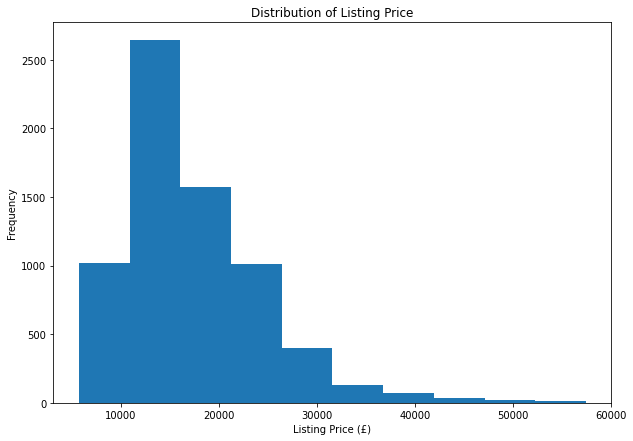

In [26]:
plt.figure(figsize = (10, 7))
plt.title('Distribution of Listing Price')
plt.xlabel("Listing Price (£)")
plt.ylabel("Frequency")
plt.hist(df['listing_price'], bins = 10);
plt.savefig('../images/listing_price_dist.png', transparent=True, bbox_inches='tight')
plt.show()

#### Creating the `car_age` Column

Once `car_age` is calculated, the `reg_date` column will be removed.

Cars from 2022 will be assigned a value of 0.5.

In [150]:
df['reg_date'] = df['reg_date'].str.split(' ').str[1]
df['reg_date'] = df['reg_date'].astype(int)

df['car_age'] = 2022 - df['reg_date']
df['car_age'].replace([0], 0.5, inplace = True)

df = df.drop(columns =['reg_date'])

In [151]:
df['car_age'].value_counts()

3.0    1839
4.0    1657
5.0    1255
6.0     847
2.0     599
1.0     423
7.0     259
0.5      29
8.0       1
Name: car_age, dtype: int64

#### Refining the Mileage Column

In [152]:
df['mileage'] = df['mileage'].str.replace('miles','')
df['mileage'] = df['mileage'].str.replace(',','')
df['mileage'] = df['mileage'].astype(int)

#### Refining the Color Column

Many Car makes have their own color definitions, as such we need to standardize these into a pre-determined subset of the most common car colors.

In [153]:
list_of_colors = ['Red', 'Blue', 'Black', 'White', 'Grey', 'Silver', 'Orange', 'Green']

def color(value):
    for i in value.split(' '):
        if i.title() in list_of_colors:
            return i.title()
    return 'Other'

df['color'] = df['color'].apply(color)
df["color"].value_counts()

Black     1350
White     1321
Grey      1320
Blue      1056
Red        866
Silver     642
Other      199
Orange     101
Green       54
Name: color, dtype: int64

#### Saving the Model-Ready Dataframe

In [154]:
df.to_csv('../datasets/cazoo_cleaned.csv', index = False)